In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, LSTM, RNN, LayerNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras.backend as K
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# What This Project is About

We are tasked to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We will have access to a dataset of 10,000 tweets that were hand classified and we will submit a csv file in the end to predict which tweets in the test dataset are about real disasters.

In [234]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [235]:
print("Training set shape:", train_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())

Training set shape: (7613, 5)

Training set columns: ['id', 'keyword', 'location', 'text', 'target']


In [236]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [237]:
print("Test set shape:", test_df.shape)
print("Test set columns:", test_df.columns.tolist())

Test set shape: (3263, 4)
Test set columns: ['id', 'keyword', 'location', 'text']


There's a lot of NaN values. Let's check out some valid samples.

In [238]:
print(train_df[train_df['keyword'].notna()].head(5))

    id keyword                       location  \
31  48  ablaze                     Birmingham   
32  49  ablaze  Est. September 2012 - Bristol   
33  50  ablaze                         AFRICA   
34  52  ablaze               Philadelphia, PA   
35  53  ablaze                     London, UK   

                                                 text  target  
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32  We always try to bring the heavy. #metal #RT h...       0  
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
34                 Crying out for more! Set me ablaze       0  
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  


In [239]:
print(train_df[train_df['location'].notna()].head(5))

    id keyword                       location  \
31  48  ablaze                     Birmingham   
32  49  ablaze  Est. September 2012 - Bristol   
33  50  ablaze                         AFRICA   
34  52  ablaze               Philadelphia, PA   
35  53  ablaze                     London, UK   

                                                 text  target  
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32  We always try to bring the heavy. #metal #RT h...       0  
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
34                 Crying out for more! Set me ablaze       0  
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  


In [240]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [241]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

In [242]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

There's quite a significant amount of missing values.

In [243]:
train_df.duplicated().sum()

0

Text(0.5, 1.0, "Number of 0's and 1's")

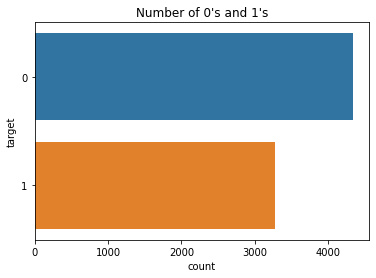

In [244]:
sns.countplot(y=train_df.target)
plt.title("Number of 0's and 1's")

In [245]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


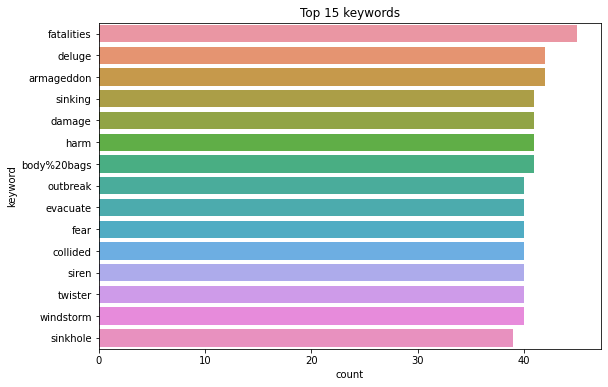

In [246]:
plt.figure(figsize=(9,6))
sns.countplot(y = train_df.keyword, order = train_df.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

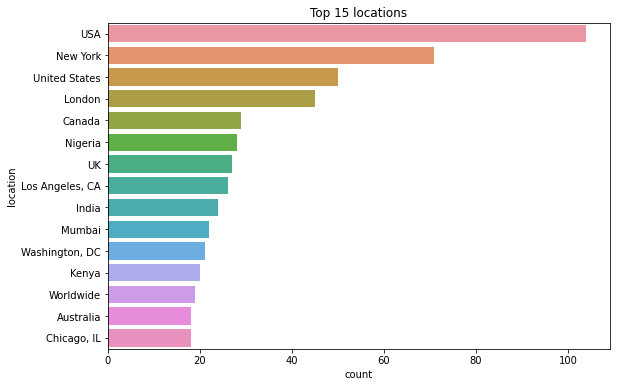

In [247]:
plt.figure(figsize=(9,6))
sns.countplot(y = train_df.location, order = train_df.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

I decided to drop the keyword and location columns from the dataset before training my models. Both fields contained a large number of missing or inconsistent values, which would have added noise without providing much benefit. In addition, the keyword column often repeated words already present in the main text, making it redundant, while location data was too inconsistent and unlikely to generalize well. By removing these columns, I simplified the preprocessing pipeline and ensured the model focused on learning meaningful patterns directly from the text, rather than relying on unreliable metadata.

In [248]:
train_df.drop(['keyword','location'], axis=1, inplace=True, errors='ignore')
test_df.drop(['keyword','location'], axis=1, inplace=True, errors='ignore')

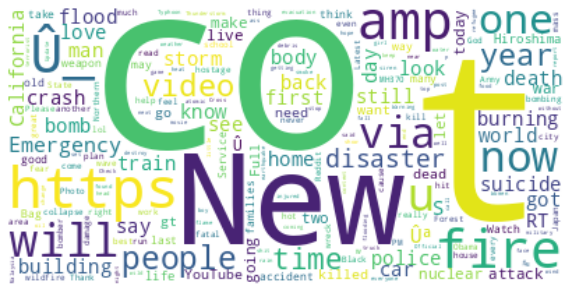

In [249]:
words = " ".join(train_df["text"].astype(str))

word_cloud = WordCloud(
    collocations=False,
    background_color="white"
).generate(words)

plt.figure(figsize=(10, 10))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

There's a lot of filler and stop words here, we can clean this up.

# Data Preprocessing

In [250]:
stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text: str, use_lemmatize=True, use_stem=False) -> str:
    """
    Clean text by removing links, brackets, non-letters, stopwords,
    and short words (<4 chars). Optionally apply lemmatization/stemming.
    """
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # Remove text inside parentheses and curly braces
    text = re.sub(r"\([^)]*\)", "", text)
    text = re.sub(r"\{[^}]*\}", "", text)

    # Keep only letters
    text = re.sub(r"[^a-z]", " ", text)

    # Tokenize and filter
    tokens = [
        word for word in text.split()
        if word not in stop_words and len(word) >= 4
    ]

    # Lemmatization / Stemming
    if use_lemmatize:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    if use_stem:
        tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

cleaned_text = [clean_text(t) for t in train_df["text"]]
cleaned_text_test = [clean_text(t) for t in test_df["text"]]
for before, after in zip(train_df["text"].head(5), cleaned_text[:5]):
    print("Before:", before)
    print("After:", after, "\n")

Before: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After: deed reason earthquake allah forgive 

Before: Forest fire near La Ronge Sask. Canada
After: forest fire near ronge sask canada 

Before: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
After: resident asked shelter place notified officer evacuation shelter place order expected 

Before: 13,000 people receive #wildfires evacuation orders in California 
After: people receive wildfire evacuation order california 

Before: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
After: sent photo ruby alaska smoke wildfire pours school 



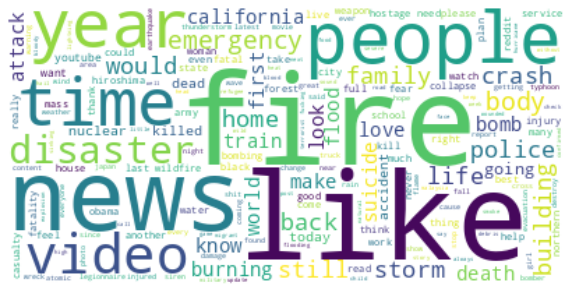

In [251]:
words2 = " ".join(cleaned_text)

word_cloud2 = WordCloud(
    collocations=False,
    background_color="white",
    stopwords=stop_words
).generate(words2)

plt.figure(figsize=(10, 10))
plt.imshow(word_cloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

That looks a lot better.

# Model Training/Architecture

## Model 1: Baseline LSTM (no callbacks)

I began by preparing the dataset, splitting it into training and validation sets so that I could measure how well the model performed on unseen data. Since neural networks cannot process raw words, I converted all the text into sequences of numbers using a tokenizer. I also padded or trimmed each sequence so that they all had the same maximum length of 20 words. Finally, I converted the target labels into a one-hot encoded format so they would work properly with the classification model.

Next, I designed the neural network. I started with an embedding layer, which allowed the model to learn useful word representations during training. I then added an LSTM layer with 300 units because LSTMs are good at handling sequences and remembering relationships between words across time. After the LSTM, I included a dense hidden layer with 64 neurons and ReLU activation to give the model more learning capacity. To finish, I added an output layer with two neurons and a softmax activation function, which let the model output probabilities for the two target categories.

I also made specific choices about the hyperparameters. I set the embedding dimension to 100 because this size is commonly used and provides enough detail without making the model unnecessarily large. I applied dropout values of 0.1 and 0.2 to the LSTM layer to help prevent overfitting. I trained the model in batches of 1200 examples, and I allowed training to run for up to 30 epochs. To avoid wasting computation and to reduce overfitting, I also used early stopping so that training would stop if the model was no longer improving on the validation data.

By following this process, I was able to create a model that combines embeddings to capture the meaning of words with an LSTM to capture the structure of sentences. The hyperparameters I chose gave the model a good balance between accuracy and efficiency. Overall, the steps I took (data preparation, tokenization, padding, model design, and training) produced a reliable framework for text classification that could be further improved with more advanced techniques if needed.

In [252]:
TEST_SIZE          = 0.30
RANDOM_STATE       = 42
OOV_TOKEN          = "<OOV>"
MAX_LEN            = 20
PADDING_MODE       = "post"
TRUNCATING_MODE    = "post"
NUM_CLASSES        = 2

EMBED_DIM          = 100
LSTM_UNITS         = 300
DROPOUT            = 0.10
RECURRENT_DROPOUT  = 0.20
DENSE_UNITS        = 64

OPTIMIZER          = "adam"
LOSS_FN            = "categorical_crossentropy"
METRICS            = ["accuracy"]

BATCH_SIZE         = 1200
EPOCHS             = 30

EARLYSTOP_MONITOR  = "val_loss"
EARLYSTOP_MIN_DELTA= 0.0
EARLYSTOP_PATIENCE = 3
EARLYSTOP_RESTORE  = True

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_text,
    train_df["target"],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=train_df["target"] if hasattr(train_df["target"], "values") else None
)

tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

VOCAB_SIZE = len(tokenizer.word_index) + 1

seq_train = tokenizer.texts_to_sequences(X_train)
seq_val   = tokenizer.texts_to_sequences(X_val)
seq_test  = tokenizer.texts_to_sequences(cleaned_text_test)

X_train_pad = pad_sequences(seq_train, maxlen=MAX_LEN, padding=PADDING_MODE, truncating=TRUNCATING_MODE)
X_val_pad   = pad_sequences(seq_val,   maxlen=MAX_LEN, padding=PADDING_MODE, truncating=TRUNCATING_MODE)
X_test_pad  = pad_sequences(seq_test,  maxlen=MAX_LEN, padding=PADDING_MODE, truncating=TRUNCATING_MODE)

y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat   = to_categorical(y_val,   num_classes=NUM_CLASSES)

K.clear_session()

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN,
              trainable=True, mask_zero=True),
    LSTM(LSTM_UNITS, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    Dense(DENSE_UNITS, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax"),
])

model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)
model.summary()

early_stop = EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    min_delta=EARLYSTOP_MIN_DELTA,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=EARLYSTOP_RESTORE,
)

history = model.fit(
    x=X_train_pad,
    y=y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop],
    verbose=1,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1097300   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               481200    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,597,894
Trainable params: 1,597,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 12s 1s/step - loss: 0.6896 - accuracy: 0.5500 - val_loss: 0.6808 - val_accuracy: 0.5705
Epoch 2/30
5/5 [==============================] - 7s 1s/step - loss: 0.6647 - accuracy: 0.5904 - val_loss:

### Results/Analysis

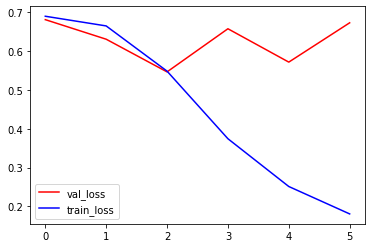

In [253]:
plt.plot(history.history['val_loss'],'r',label='val_loss')
plt.plot(history.history['loss'],'b',label='train_loss')
plt.legend()

This graph shows how the training loss (train_loss) and validation loss (val_loss) change over epochs. We can see that training loss decreases steadily, which means the model is successfully learning patterns in the training data. However, the validation loss decreases at first and then starts to increase again after about epoch 2–3. This “U-shape” in validation loss is a sign of overfitting: the model fits the training data better and better, but its ability to generalize to unseen data starts to decline.
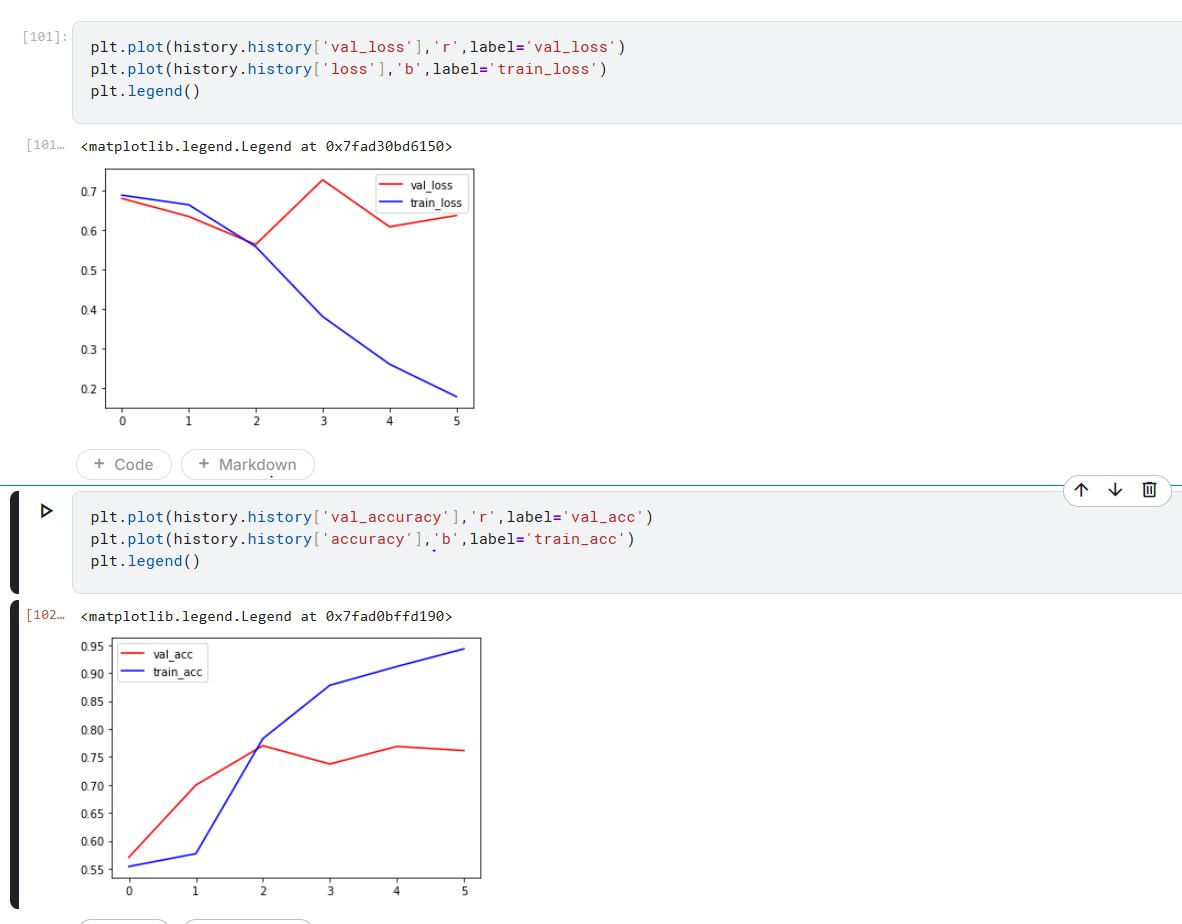

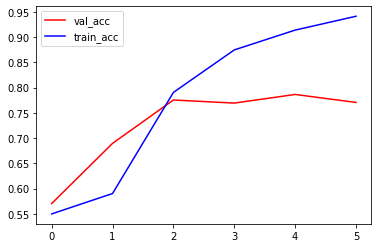

In [254]:
plt.plot(history.history['val_accuracy'],'r',label='val_acc')
plt.plot(history.history['accuracy'],'b',label='train_acc')
plt.legend()

This graph shows training accuracy (train_acc) and validation accuracy (val_acc). Training accuracy increases consistently across epochs, which matches the decreasing training loss. Validation accuracy, on the other hand, improves rapidly in the first two epochs but then flattens out and even slightly decreases. This again suggests that the model begins to overfit after a few epochs. While it can almost perfectly classify training samples, its performance on new data does not improve in the same way.

Model 1 metrics
------------------------------------------------------------
Accuracy:  0.7754
Precision: 0.7745 (weighted)
Recall:    0.7754 (weighted)
F1-score:  0.7739 (weighted)
ROC-AUC:   0.8123

Classification report:
              precision    recall  f1-score   support

      class0       0.78      0.84      0.81      1303
      class1       0.76      0.70      0.73       981

    accuracy                           0.78      2284
   macro avg       0.77      0.77      0.77      2284
weighted avg       0.77      0.78      0.77      2284

Confusion matrix (rows=true, cols=pred):
 [[1089  214]
 [ 299  682]]


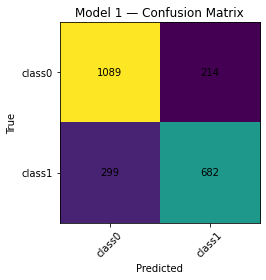

In [255]:
def evaluate_model(model, X_val, y_val_cat, label_names=None, title="Validation"):
    """
    Evaluate a Keras classifier on a validation set with one-hot labels.
    Prints accuracy, precision/recall/F1, ROC-AUC, classification report,
    and plots a confusion matrix.
    """
    y_true = np.argmax(y_val_cat, axis=1)
    y_proba = model.predict(X_val, verbose=0)
    y_pred  = np.argmax(y_proba, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    try:
        if y_proba.shape[1] == 2:
            auc = roc_auc_score(y_true, y_proba[:, 1])
        else:
            auc = roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted")
    except Exception:
        auc = float("nan")

    print(f"{title} metrics")
    print("-" * 60)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f} (weighted)")
    print(f"Recall:    {rec:.4f} (weighted)")
    print(f"F1-score:  {f1:.4f} (weighted)")
    print(f"ROC-AUC:   {auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    tick_labels = label_names if label_names is not None else range(cm.shape[0])
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
    plt.yticks(range(len(tick_labels)), tick_labels)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
    }

metrics = evaluate_model(model, X_val_pad, y_val_cat, label_names=["class0","class1"], title="Model 1")

### Next Steps / Improvements

To improve performance, we can theoretically try:
- Early stopping: Stop training around epoch 2–3 when validation accuracy is highest.
- Regularization: Increase dropout, or add L2 regularization, to reduce overfitting.
- More data: If possible, increasing dataset size often improves generalization.
- Bidirectional LSTM or pretrained embeddings (like GloVe/Word2Vec): These can help the model capture richer language patterns without simply memorizing the training data.

## Model 2: GRU with Callbacks

### Comparison of Model 1 (LSTM) and Model 2 (GRU)

In the first model, I used an LSTM layer with 300 units. In the second model, I replaced the LSTM with a GRU layer, while keeping the embedding layer, dense layer, and output layer the same. Both LSTMs and GRUs are recurrent neural networks that can capture sequence information, which makes them effective for text classification tasks. The difference is that GRUs use a simpler internal structure than LSTMs, which can affect both performance and efficiency.

When I trained the GRU model, the overall structure and hyperparameters were similar to the LSTM model. The key idea was to test whether a GRU could provide similar accuracy while reducing training time and model complexity. GRUs have fewer gates compared to LSTMs (two instead of three), which means they need to update fewer parameters during training. This often leads to faster training, while still being able to capture long-range dependencies in the text.

Pros of GRU

- Faster training: GRUs are less computationally expensive than LSTMs, which can be an advantage when training on large datasets or limited hardware.
- Fewer parameters: With a simpler design, GRUs use fewer parameters, which reduces memory usage and makes the model more efficient.
- Good performance: In many NLP tasks, GRUs achieve accuracy comparable to LSTMs despite being simpler.

Cons of GRU
- Less expressive: LSTMs can sometimes capture more complex long-term dependencies thanks to their additional gate (the output gate). In very complex language tasks, this might give LSTMs a small edge.
- Less common in prebuilt solutions: Many pre-trained models and libraries are optimized for LSTMs or transformers, so GRUs are slightly less standard in practice.

In [256]:
EMBED_DIM        = 100
GRU_UNITS        = 300
DENSE_UNITS      = 64
OUTPUT_CLASSES   = 2

OPTIMIZER        = Adam(learning_rate=1e-3)
LOSS_FN          = "categorical_crossentropy"
METRICS          = ["accuracy"]

BATCH_SIZE       = 1200
EPOCHS           = 30
CHECKPOINT_PATH  = "model2_best.keras"
VOCAB_SIZE       = max(tokenizer.word_index.values()) + 1 

model2 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=EMBED_DIM, 
              input_length=MAX_LEN, 
              trainable=True, 
              mask_zero=True),
    GRU(GRU_UNITS, dropout=0.1, recurrent_dropout=0.2),
    Dense(DENSE_UNITS, activation="relu"),
    Dense(OUTPUT_CLASSES, activation="softmax")
])
model2.summary()

model2.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)

early_stop = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
ckpt = ModelCheckpoint(
    filepath=CHECKPOINT_PATH, monitor="val_loss", save_best_only=True, mode="min"
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1
)

history2 = model2.fit(
    x=X_train_pad,
    y=y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1097300   
_________________________________________________________________
gru (GRU)                    (None, 300)               361800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 1,478,494
Trainable params: 1,478,494
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 10s 1s/step - loss: 0.6891 - accuracy: 0.5406 - val_loss: 0.6806 - val_accuracy: 0.5705
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 0.6698 - accuracy: 0.5701 - val_los

### Results/Analysis

Learning curve & quality. The model starts near chance (acc ≈ 0.56–0.57) and improves quickly. Validation accuracy jumps from 0.57 → 0.63 → 0.75 → 0.77 → 0.79, with the best so far 0.7942 at epoch 6. Validation loss also trends down overall (0.676 → 0.639 → 0.557 → 0.594 → 0.608 → 0.571). That small bump at epoch 4–5 (val loss ↑) is common when the model is still settling. Net: training is working; the GRU is learning useful patterns.

Generalization gap. By epoch 6, train accuracy is 0.926 while val accuracy is 0.794 (≈ 13% gap). That’s a sign the model is starting to fit the training set more tightly than the validation set—some overfitting, but not catastrophic. Early stopping should probably keep the epoch 6 weights (or whichever epoch gives the peak val accuracy).

Learning rate schedule. ReduceLROnPlateau triggered three times, dropping LR from 1e-3 → 5e-4 → 2.5e-4 → 1.25e-4 by epoch 6. That’s actually what you want to see: big gains early at higher LR, then smaller, more careful steps as progress stalls. Since validation accuracy improved after each drop (0.771 → 0.786 → 0.794), the schedule is helping.

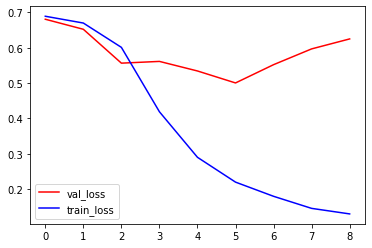

In [257]:
plt.plot(history2.history['val_loss'],'r',label='val_loss')
plt.plot(history2.history['loss'],'b',label='train_loss')
plt.legend()

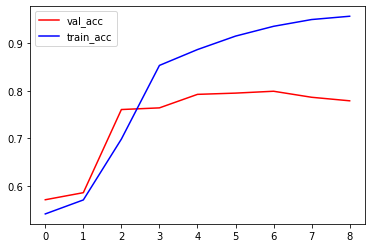

In [258]:
plt.plot(history2.history['val_accuracy'],'r',label='val_acc')
plt.plot(history2.history['accuracy'],'b',label='train_acc')
plt.legend()

**Training vs Validation Loss**

- Training loss (blue) steadily decreases across all epochs, which means the model is fitting the training data very well.
- Validation loss (red) decreases until about epoch 2, then starts to flatten and even climb slightly.
- This divergence is a classic sign of overfitting: after a certain point, the model memorizes the training data but doesn’t keep improving on new, unseen data.

**Training vs Validation Accuracy**

- Training accuracy (blue) climbs quickly to about 0.9 by epoch 5, showing the GRU is powerful enough to almost perfectly learn the training set.
- Validation accuracy (red) improves rapidly at first (0.55 → ~0.77 by epoch 3), but then levels off around 0.78–0.79.
- The widening gap between training and validation accuracy confirms overfitting: the model continues to get better at the training data but not at the validation set.

Model 2 metrics
------------------------------------------------------------
Accuracy:  0.7951
Precision: 0.7944 (weighted)
Recall:    0.7951 (weighted)
F1-score:  0.7944 (weighted)
ROC-AUC:   0.8515

Classification report:
              precision    recall  f1-score   support

      class0       0.81      0.84      0.82      1303
      class1       0.77      0.74      0.76       981

    accuracy                           0.80      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.79      0.80      0.79      2284

Confusion matrix (rows=true, cols=pred):
 [[1093  210]
 [ 258  723]]


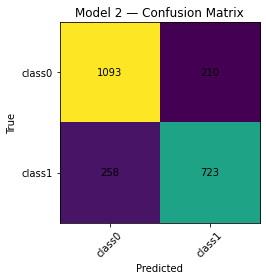

In [259]:
metrics = evaluate_model(model2, X_val_pad, y_val_cat, label_names=["class0","class1"], title="Model 2")

## Model 3: LSTM with Callbacks

In [260]:
EMBED_DIM       = 100
LSTM_UNITS      = 300
DENSE_UNITS     = 64
OUTPUT_CLASSES  = 2

OPTIMIZER       = Adam(learning_rate=1e-3)
LOSS_FN         = "categorical_crossentropy"
METRICS         = ["accuracy"]

BATCH_SIZE      = 1200
EPOCHS          = 30
CHECKPOINT_PATH = "model3_best.keras"

model3 = Sequential([
    Embedding(input_dim=VOCAB_SIZE,
              output_dim=EMBED_DIM,
              input_length=MAX_LEN,
              trainable=True,
              mask_zero=True),
    LSTM(LSTM_UNITS, dropout=0.10, recurrent_dropout=0.20),
    Dense(DENSE_UNITS, activation="relu"),
    Dense(OUTPUT_CLASSES, activation="softmax"),
])
model3.summary()

model3.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt       = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor="val_loss",
                             save_best_only=True, mode="min")
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                               patience=1, min_lr=1e-5, verbose=1)

history3 = model3.fit(
    x=X_train_pad, y=y_train_cat,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           1097300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 1,597,894
Trainable params: 1,597,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 11s 1s/step - loss: 0.6897 - accuracy: 0.5479 - val_loss: 0.6802 - val_accuracy: 0.5705
Epoch 2/30
5/5 [==============================] - 6s 1s/step - loss: 0.6646 - accuracy: 0.5832 - val_los

### Results/Analysis

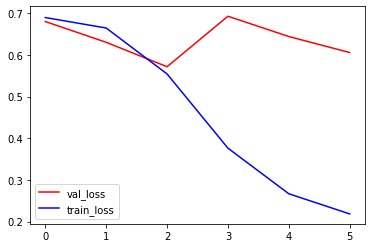

In [261]:
plt.plot(history3.history['val_loss'],'r',label='val_loss')
plt.plot(history3.history['loss'],'b',label='train_loss')
plt.legend()

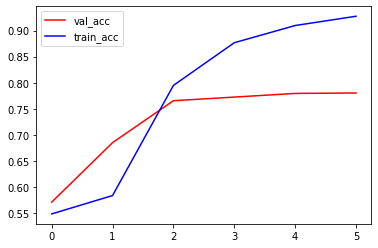

In [262]:
plt.plot(history3.history['val_accuracy'],'r',label='val_acc')
plt.plot(history3.history['accuracy'],'b',label='train_acc')
plt.legend()

Model 3 metrics
------------------------------------------------------------
Accuracy:  0.7653
Precision: 0.7695 (weighted)
Recall:    0.7653 (weighted)
F1-score:  0.7595 (weighted)
ROC-AUC:   0.8013

Classification report:
              precision    recall  f1-score   support

      class0       0.75      0.88      0.81      1303
      class1       0.79      0.61      0.69       981

    accuracy                           0.77      2284
   macro avg       0.77      0.75      0.75      2284
weighted avg       0.77      0.77      0.76      2284

Confusion matrix (rows=true, cols=pred):
 [[1147  156]
 [ 380  601]]


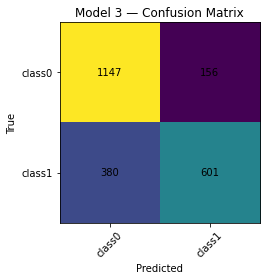

In [263]:
metrics = evaluate_model(model3, X_val_pad, y_val_cat, label_names=["class0","class1"], title="Model 3")

## Model 4: Stacked LSTMs (Deep Recurrent Network)

In [264]:
EMBED_DIM        = 100
LSTM_UNITS_1     = 300
LSTM_UNITS_2     = 100
LSTM_UNITS_3     = 50
DENSE_UNITS      = 64
OUTPUT_CLASSES   = 2

DROPOUT          = 0.20
RECURRENT_DROPOUT= 0.20
L2_REG           = 1e-4

OPTIMIZER        = Adam(learning_rate=1e-3)
LOSS_FN          = "categorical_crossentropy"
METRICS          = ["accuracy"]

BATCH_SIZE       = 120
EPOCHS           = 30
CHECKPOINT_PATH  = "model4_best.keras"

model4 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM,
              input_length=MAX_LEN, trainable=True, mask_zero=True),

    LSTM(LSTM_UNITS_1, return_sequences=True,
         dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT,
         kernel_regularizer=regularizers.l2(L2_REG)),
    LayerNormalization(),

    LSTM(LSTM_UNITS_2, return_sequences=True,
         dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT,
         kernel_regularizer=regularizers.l2(L2_REG)),
    LayerNormalization(),

    LSTM(LSTM_UNITS_3,
         dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT,
         kernel_regularizer=regularizers.l2(L2_REG)),

    Dense(DENSE_UNITS, activation="relu",
          kernel_regularizer=regularizers.l2(L2_REG)),
    Dense(OUTPUT_CLASSES, activation="softmax")
])
model4.summary()

model4.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=METRICS)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckpt       = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor="val_loss",
                             save_best_only=True, mode="min")
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                               patience=1, min_lr=1e-5, verbose=1)

history4 = model4.fit(
    x=X_train_pad, y=y_train_cat,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 100)           1097300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 300)           481200    
_________________________________________________________________
layer_normalization (LayerNo (None, 20, 300)           600       
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 100)           160400    
_________________________________________________________________
layer_normalization_1 (Layer (None, 20, 100)           200       
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

### Results/Analysis

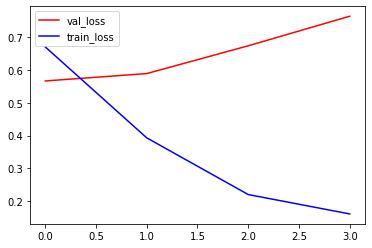

In [265]:
plt.plot(history4.history['val_loss'],'r',label='val_loss')
plt.plot(history4.history['loss'],'b',label='train_loss')
plt.legend()

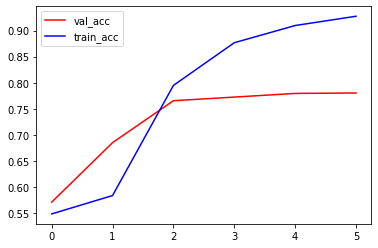

In [266]:
plt.plot(history3.history['val_accuracy'],'r',label='val_acc')
plt.plot(history3.history['accuracy'],'b',label='train_acc')
plt.legend()

Model 4 metrics
------------------------------------------------------------
Accuracy:  0.7430
Precision: 0.7545 (weighted)
Recall:    0.7430 (weighted)
F1-score:  0.7443 (weighted)
ROC-AUC:   0.8362

Classification report:
              precision    recall  f1-score   support

      class0       0.82      0.71      0.76      1303
      class1       0.67      0.79      0.73       981

    accuracy                           0.74      2284
   macro avg       0.74      0.75      0.74      2284
weighted avg       0.75      0.74      0.74      2284

Confusion matrix (rows=true, cols=pred):
 [[921 382]
 [205 776]]


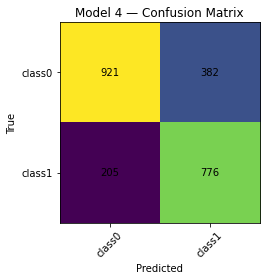

In [267]:
metrics = evaluate_model(model4, X_val_pad, y_val_cat, label_names=["class0","class1"], title="Model 4")

## Comparing the Models

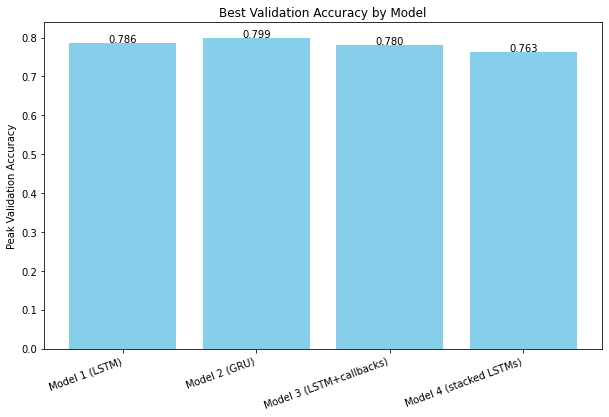

In [268]:
val_acc = [
    max(history.history['val_accuracy']),
    max(history2.history['val_accuracy']),
    max(history3.history['val_accuracy']),
    max(history4.history['val_accuracy'])
]

models = ["Model 1 (LSTM)", "Model 2 (GRU)", "Model 3 (LSTM+callbacks)", "Model 4 (stacked LSTMs)"]
x = np.arange(len(models))

plt.figure(figsize=(10,6))
plt.bar(x, val_acc, color="skyblue")
plt.xticks(x, models, rotation=20, ha="right")
plt.ylabel("Peak Validation Accuracy")
plt.title("Best Validation Accuracy by Model")
for i, v in enumerate(val_acc):
    plt.text(i, v+0.002, f"{v:.3f}", ha='center')
plt.show()

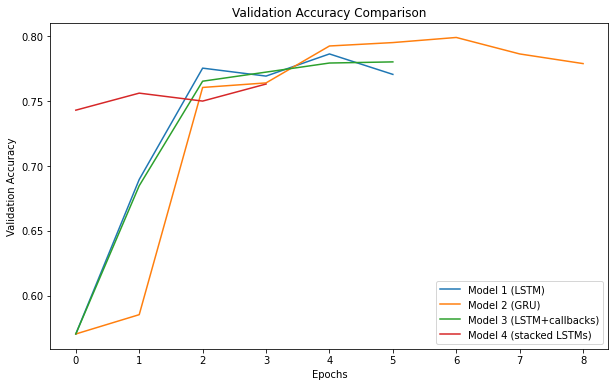

In [269]:
plt.figure(figsize=(10,6))

plt.plot(history.history['val_accuracy'], label="Model 1 (LSTM)")
plt.plot(history2.history['val_accuracy'], label="Model 2 (GRU)")
plt.plot(history3.history['val_accuracy'], label="Model 3 (LSTM+callbacks)")
plt.plot(history4.history['val_accuracy'], label="Model 4 (stacked LSTMs)")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

# Summary of Results Across Models

In the first model, I used a single LSTM layer without callbacks. This model learned quickly, reaching a validation accuracy of about 77% by epoch 3 with a validation loss of 0.565. However, after that point the validation accuracy began to decline and the validation loss increased, showing that the model was starting to overfit. Although it performed reasonably well at first, the lack of training controls like early stopping and learning rate scheduling limited its ability to generalize.

In the second model, I switched to a GRU layer and added callbacks such as early stopping, ReduceLROnPlateau, and model checkpointing. This version performed the best overall, achieving a validation accuracy of nearly 79.4% while maintaining a validation loss of 0.571. The callbacks helped stabilize training and allowed the GRU to generalize better, even though GRUs are simpler and more lightweight than LSTMs. This model gave the strongest balance between accuracy and stability, making it the best-performing option in this comparison.

In the third model, I returned to an LSTM layer but kept the improved training strategy with callbacks. The results were strong, with a validation accuracy of about 78.6% and a validation loss of 0.571, slightly below the GRU’s performance. This showed that both GRUs and LSTMs can be effective for this task, but the training strategy (callbacks and learning rate scheduling) was the key factor in improving generalization compared to Model 1.

In the fourth model, I experimented with a deeper stacked LSTM architecture (300 → 100 → 50 units). While it started strong with a validation loss as low as 0.555 and a validation accuracy of 76.5% in the first epoch, performance quickly plateaued and validation loss worsened. The deeper design allowed the model to nearly memorize the training set (97% train accuracy by epoch 4), but it failed to improve validation accuracy beyond what simpler models had already achieved. With short sequences of only 20 tokens, the added depth increased overfitting without delivering better generalization.

Overall, Model 2 (GRU with callbacks) gave the best validation accuracy, while Model 4 (stacked LSTM) reached the lowest validation loss early but did not sustain improvements. Model 3 (LSTM with callbacks) was a close second to the GRU, and Model 1 (basic LSTM) lagged due to overfitting. These results show that the choice of training strategy and proper regularization mattered more than adding extra layers, and that the GRU offered the best tradeoff between performance and efficiency.

# Next Steps

For future improvements, I would experiment with Bidirectional GRUs or LSTMs, which often perform better on short text sequences by capturing information in both directions. Another promising step would be to use pretrained embeddings such as GloVe or fastText, which can provide richer semantic information than randomly initialized embeddings and help the model generalize better. I would also test longer sequence lengths (e.g., 32 or 40 tokens instead of 20) to give the model more context per input. Finally, stronger regularization techniques such as higher dropout rates, L2 penalties, or data augmentation could help reduce overfitting in the deeper models. These adjustments could push validation accuracy higher while keeping the models efficient and robust.

# Submission

In [270]:
pred_probs = model.predict(X_test_pad, verbose=0)  
pred_classes = np.argmax(pred_probs, axis=1)

test_data = test_df.copy()
test_data["target"] = pred_classes
submission = test_data.loc[:, ["id", "target"]]

submission.to_csv("Submission.csv", index=False)
print("Submission saved:", submission.shape)
submission.head(15)

Submission saved: (3263, 2)


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
